## Global saturated matrix potential based on soil type ==> indus basin extraction

### general procedures:

#### 1. load global soil map
#### 2. upscale to 5arcmin
#### 2. assign saturated potential value based on soil type
#### 3. export a global 5arcmin
#### 4. crop to Indus



In [1]:
import numpy as np
from osgeo import gdal, osr
import os
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib
#change working directory
os.chdir('/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python')

In [2]:
# load the raster data of global soil type 
def load_raster_data(file_path):
    dataset = gdal.Open(file_path)
    band = dataset.GetRasterBand(1)
    data = band.ReadAsArray()
    return data

soilmap = load_raster_data('/lustre/nobackup/WUR/ESG/liu297/vic_indus/11indus_run/05Parameters/HWSD_USDA_TEX_CLASS.tif')

soilmap = np.where(soilmap == 255, np.nan, soilmap)



In [3]:
soil_to_potential = {  # A dictionary to map soil type to potential, unit is (m)
    1:-0.27,   #clay (heavy) 
    2:-0.58,   #silty clay
    3:-0.27,   #clay(light)
    4:-0.28,   #silty clay loam
    5:-0.63,   #clay loam
    6:-0.24,   #silt
    7:-0.84,   #silt loam
    8:-0.12,   #sandy clay    
    9:-0.65,   #loam
    10:-0.12,  #sandy clay loam
    11:-0.16,  #sandy loam
    12:-0.07,  #loamy sand
    13:-0.05   #sand
}
map_to_potential = np.vectorize(lambda x: soil_to_potential.get(x, 0)) 
potential_matrix = np.empty_like(soilmap, dtype=float)

# break the soilmap into chunks and apply the vectorized function
block_size = 100  

for i in range(0, soilmap.shape[0], block_size):
    for j in range(0, soilmap.shape[1], block_size):
        
        i_end = min(i + block_size, soilmap.shape[0])
        j_end = min(j + block_size, soilmap.shape[1])
        block = soilmap[i:i_end, j:j_end]
        potential_matrix[i:i_end, j:j_end] = map_to_potential(block)

In [8]:
#upscaling the potential matrix from 30racsec to 5 arcmin

from skimage.measure import block_reduce
block_size = (10, 10)
potential_matrix_downsampled = block_reduce(potential_matrix, block_size=block_size, func=np.mean)

In [11]:
# export the downsampled potential matrix to a GeoTIFF file
ncols, nrows = 4320, 2160
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create('saturated_matrix_potential_5arcmin.tif', ncols, nrows, 1, gdal.GDT_Float32)

x_min, y_max = -180, 90  
pixel_width, pixel_height = 360.0 / ncols, -180.0 / nrows  
geo_transform = (x_min, pixel_width, 0, y_max, 0, pixel_height)
dataset.SetGeoTransform(geo_transform)

srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
dataset.SetProjection(srs.ExportToWkt())
dataset.GetRasterBand(1).WriteArray(potential_matrix_downsampled)

dataset.FlushCache()
dataset = None


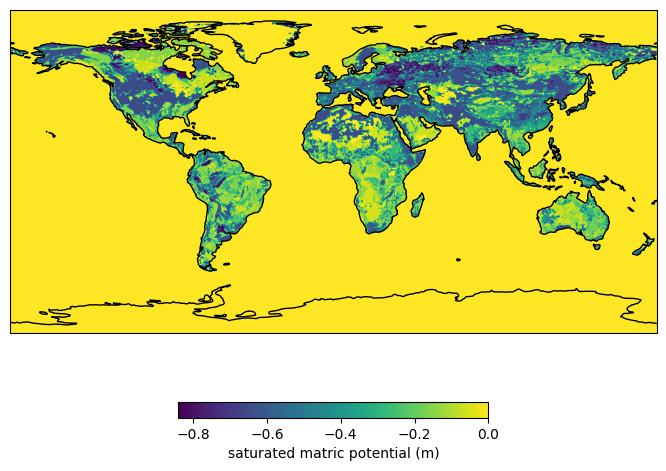

In [18]:
# visualize the raster data by cartopy
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

image = plt.imshow(potential_matrix_downsampled, origin='upper', extent=[-180,180,-90,90], transform=ccrs.PlateCarree())
cb = plt.colorbar(image, ax=ax, orientation='horizontal', label='saturated matric potential (m)',shrink = 0.4) 
#cb.ax.set_xticklabels(['heavy clay', 'silty clay', 'light clay', 'siilty clay loam', 'clay loam', 'silt', 'silt loam', 'sandy clay', 'loam', 'sandy clay loam', 'sandy loam', 'loamy sand', 'sand'])
plt.savefig('soil_potential_5arcmin.png',dpi= 250)
plt.show()

In [ ]:
# do a plot of the soil map in 30 arcsec
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
colors = plt.cm.viridis(np.linspace(0, 1, 13))  # 生成13种颜色
colors = np.vstack((colors, [0, 0, 0, 0]))  # 添加一个透明颜色用于nan
cmap = mcolors.ListedColormap(colors)
norm = mcolors.Normalize(vmin=1, vmax=13)
image = plt.imshow(soilmap, cmap=cmap, norm=norm, origin='upper', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree())
soil_types = ['heavy clay', 'silty clay', 'light clay', 'silty clay loam', 'clay loam', 'silt', 'silt loam', 'sandy clay', 'loam', 'sandy clay loam', 'sandy loam', 'loamy sand', 'sand']
patches = [mpatches.Patch(color=colors[i], label=soil_types[i]) for i in range(13)]
plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=7, title='Soil Type', frameon=False)
plt.savefig('/lustre/nobackup/WUR/ESG/liu297/gitrepo/VIC-WUR-GWM-1910/vic_online/python/soilmap.tiff', dpi=300, bbox_inches='tight')

In [ ]:
# crop matrix potential to the indus basin 
